In [3]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import itertools

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.mane_utils import *

In [4]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [5]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

sr_ab = '../'+config['sr']['ab']


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = '../../proc_revisions/ref/biomart_human_to_mouse.tsv'


mouse_ver = 'vM25_cerberus'

In [6]:
sns.set_context('paper', font_scale=1.8)
c_dict, order = get_biosample_colors()

In [7]:
ab_df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(ab_df,
               how='iso',
               min_tpm=min_tpm,
               gene_subset=gene_subset)
det_df = get_det_table(ab_df,
               how='iso',
               min_tpm=min_tpm,
               gene_subset=gene_subset)

Calculating iso TPM values
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2087: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2086: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Number of isos reported: 191325
Calculating iso TPM values
Subsetting for protein_coding genes
Enforcing minimum TPM
Total # isos detected: 236615
# isos >= 1 tpm: 213476
Applying gene type and novelty subset
Number of isos reported: 191325
Found 138 total libraries


In [8]:
# get all pairwise sets of tech reps
meta_df = pd.read_csv(lib_meta, sep='\t')
meta_df['biorep'] = meta_df['dataset'].str.rsplit('_', n=1, expand=True)[0]

all_pairs = []
for b in meta_df['biorep'].unique().tolist():
    b_datasets = meta_df.loc[meta_df.biorep==b, 'dataset'].tolist()
    pairs = list(itertools.combinations(b_datasets, 2))
    all_pairs += pairs

In [9]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1690: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


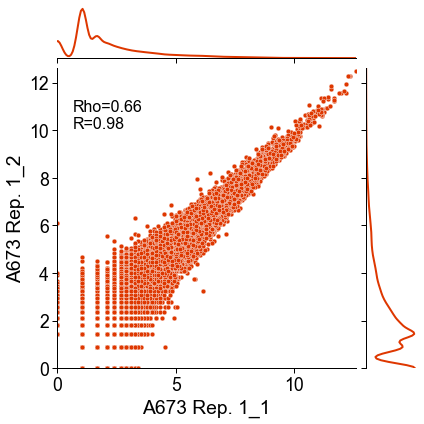

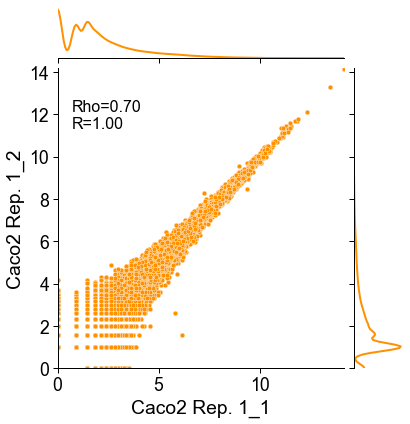

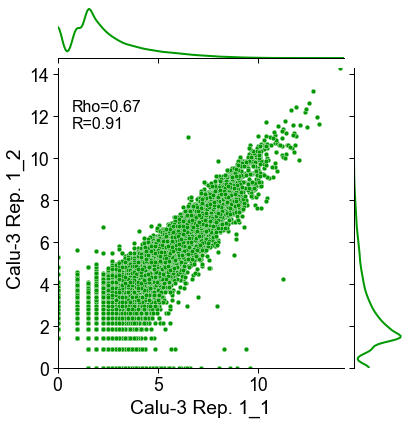

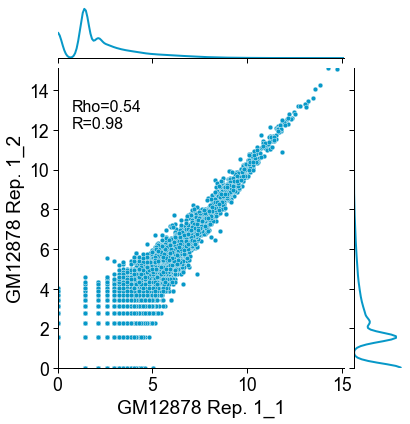

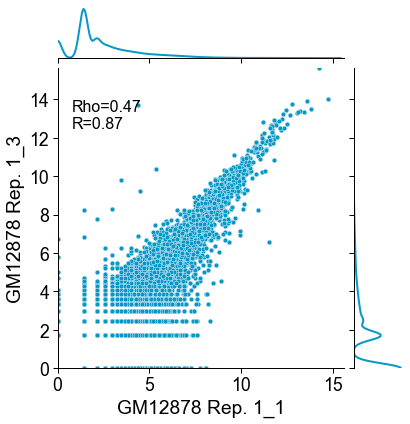

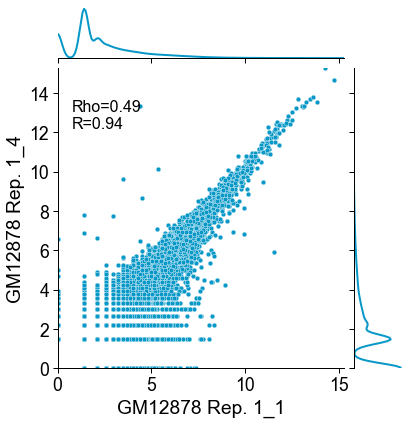

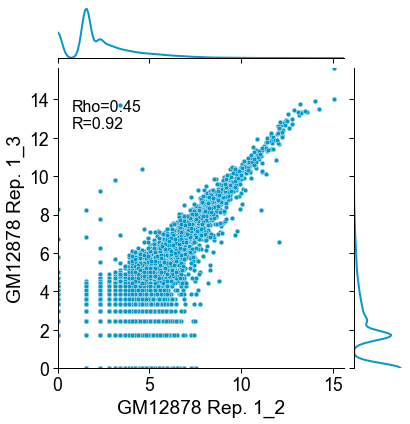

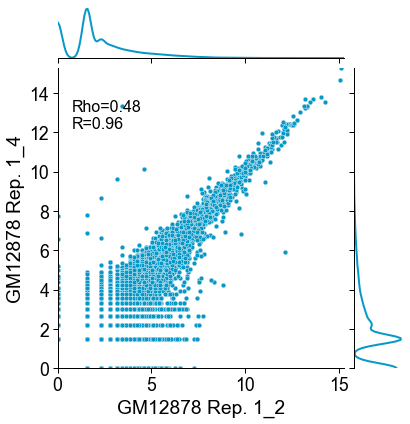

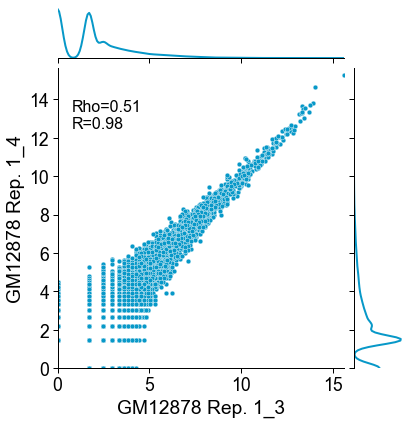

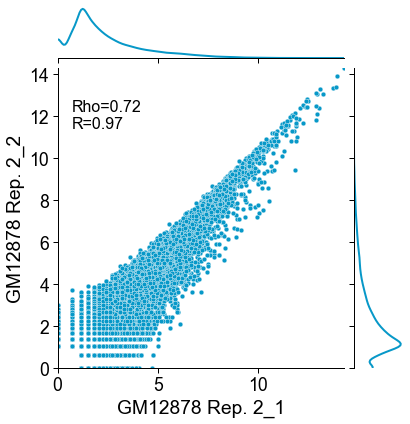

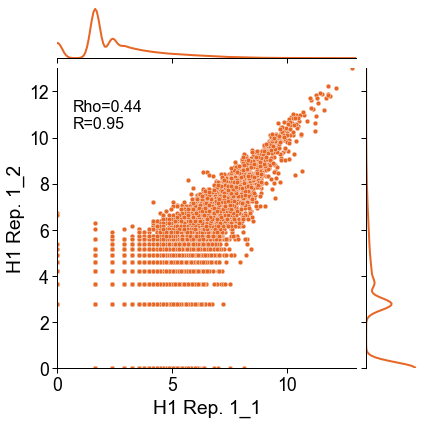

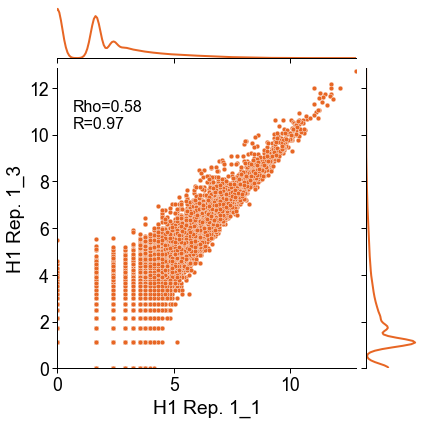

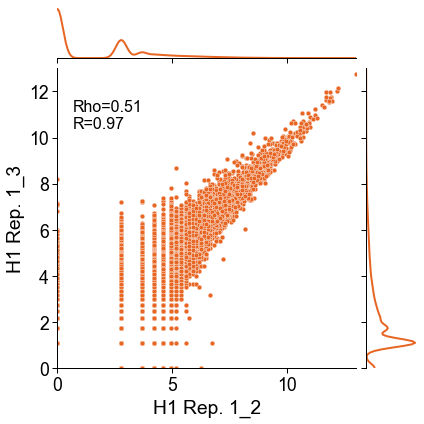

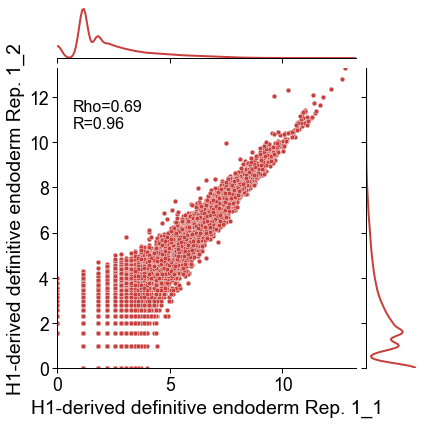

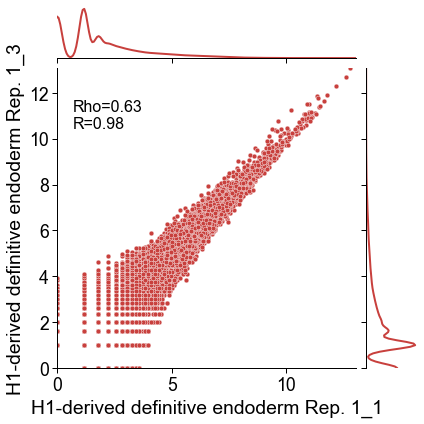

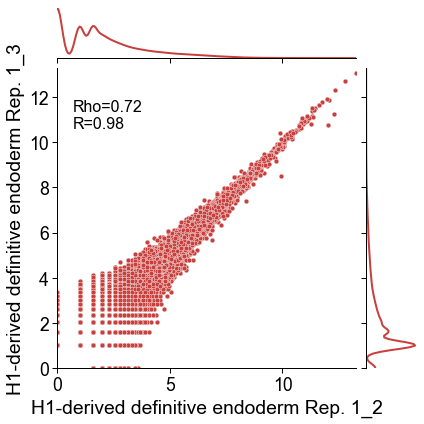

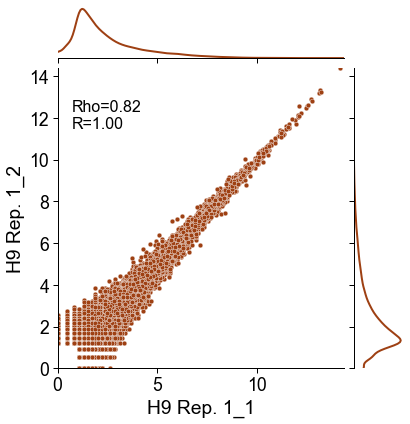

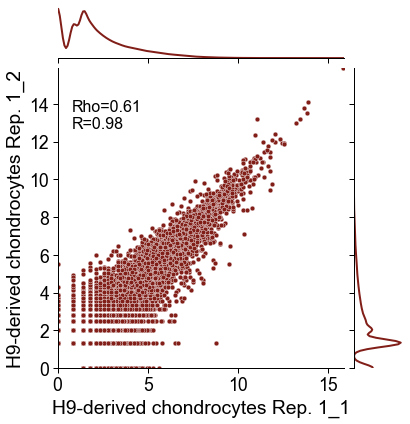

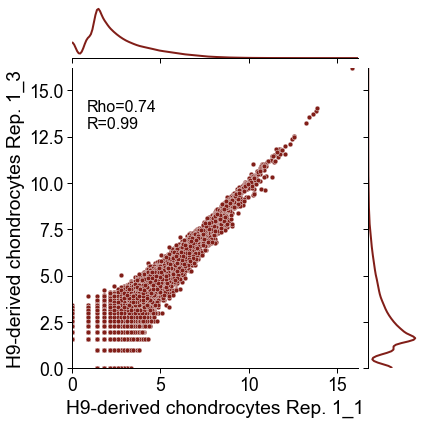

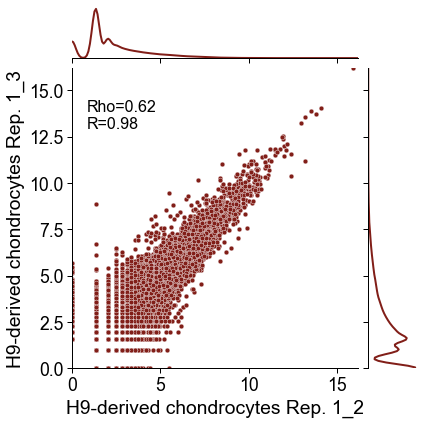

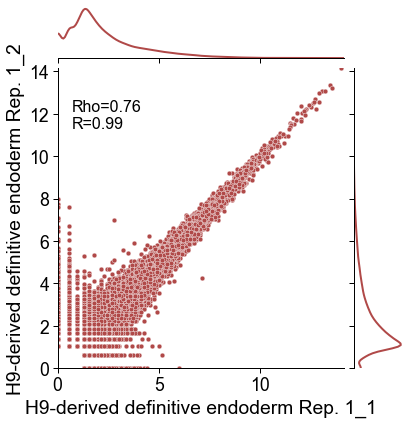

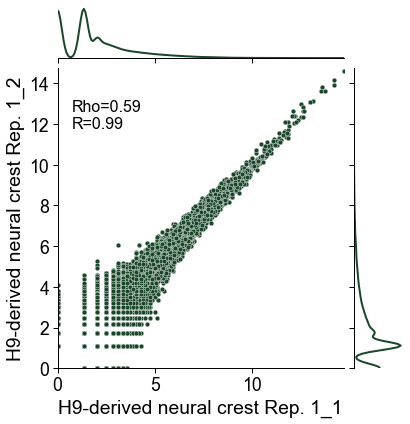

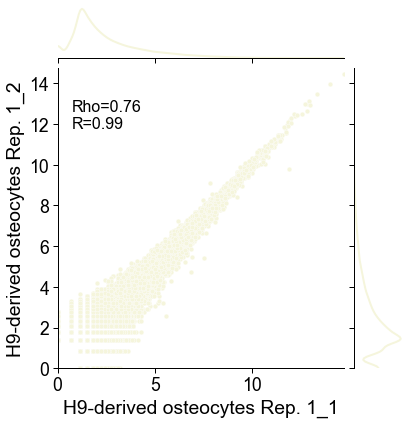

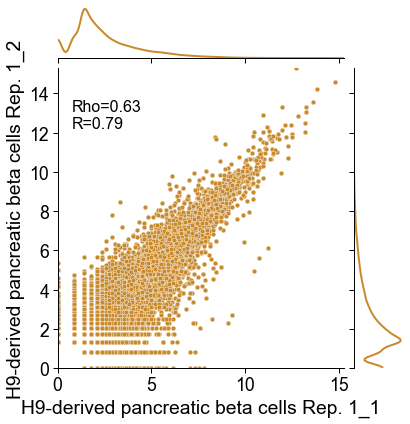

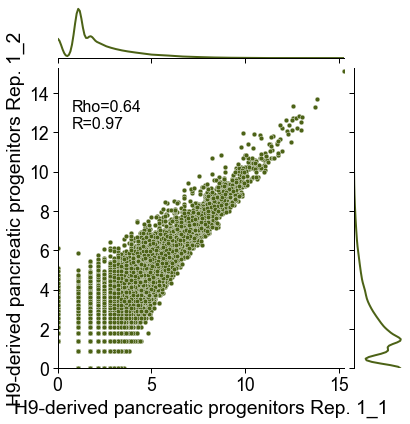

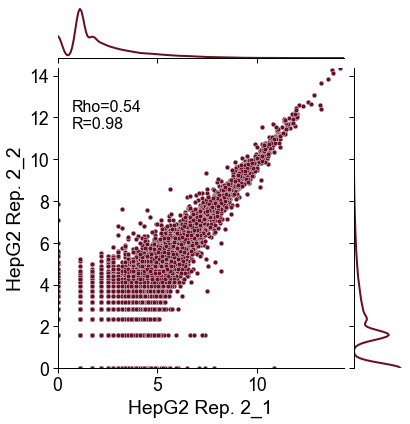

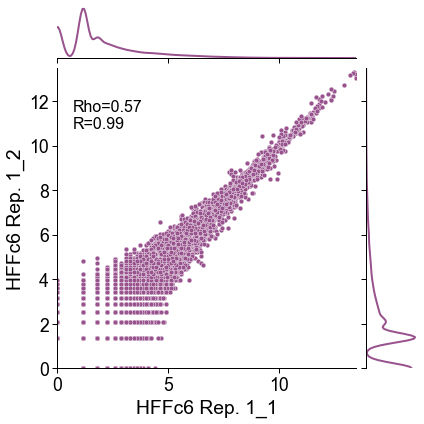

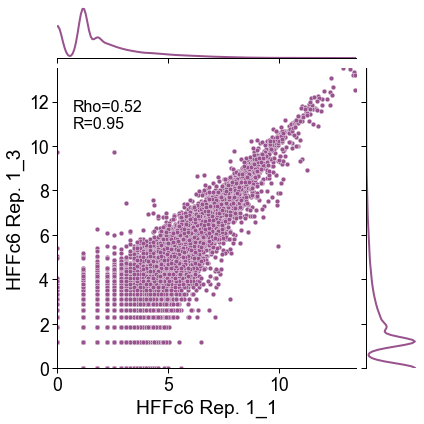

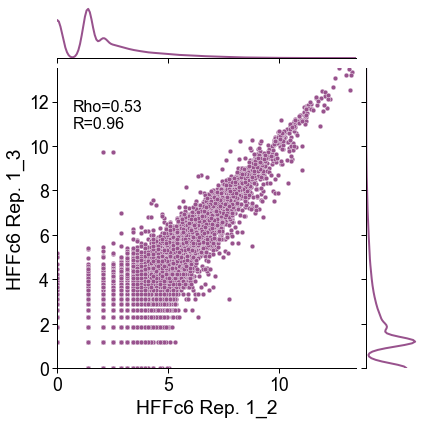

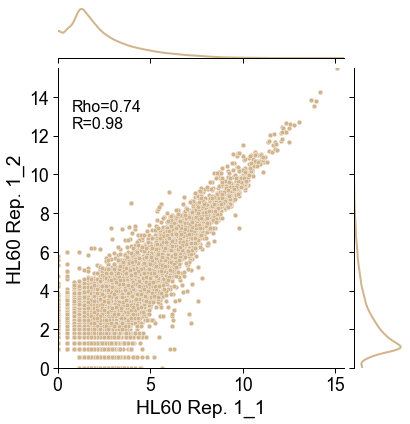

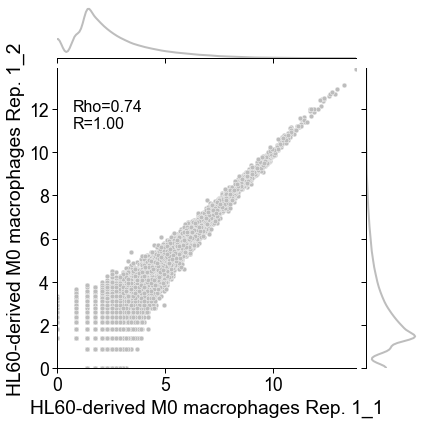

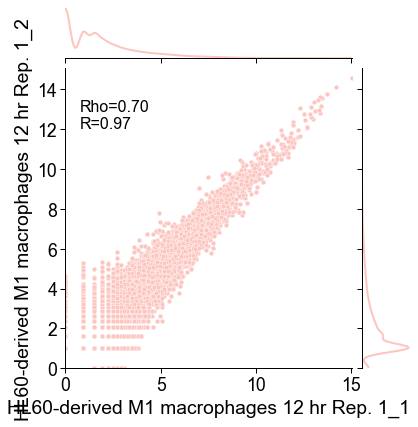

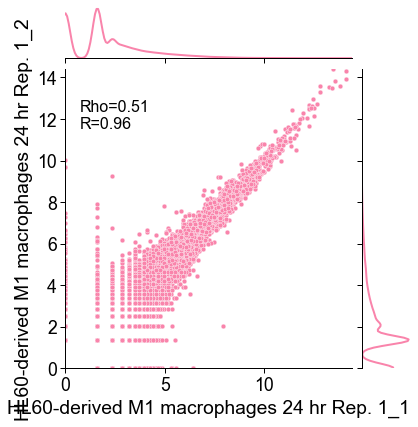

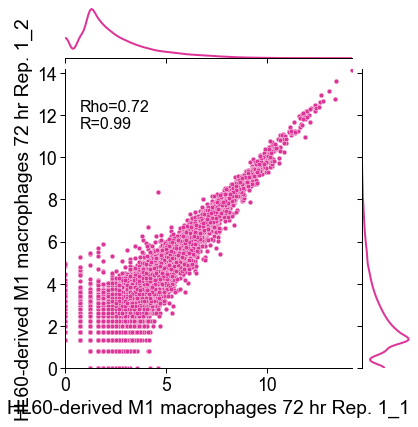

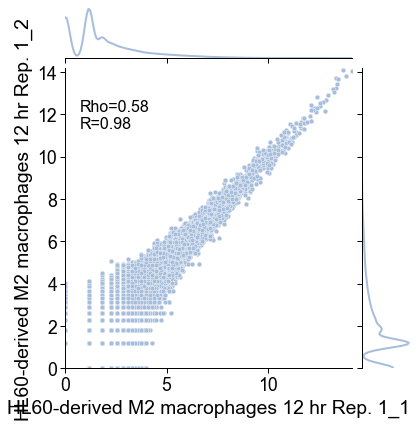

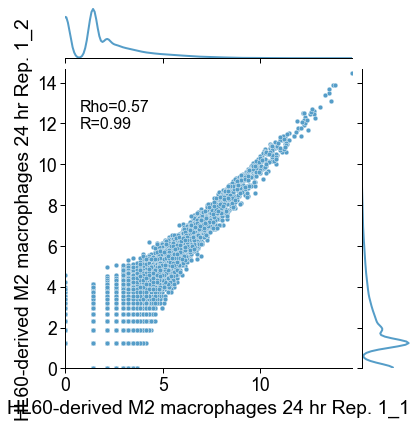

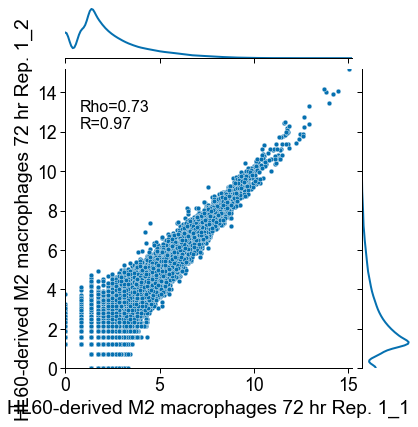

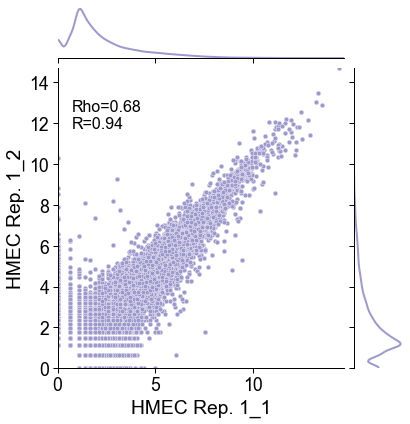

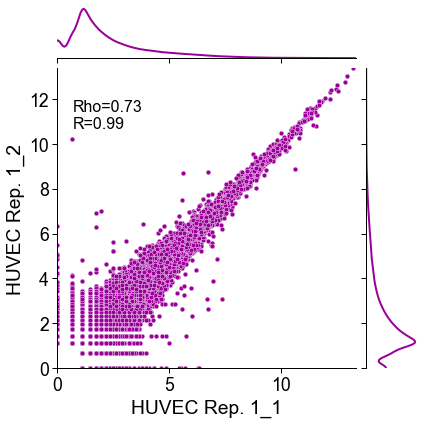

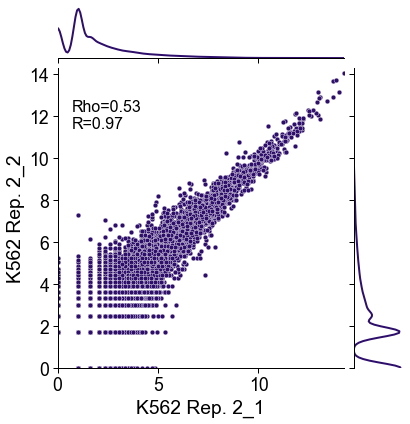

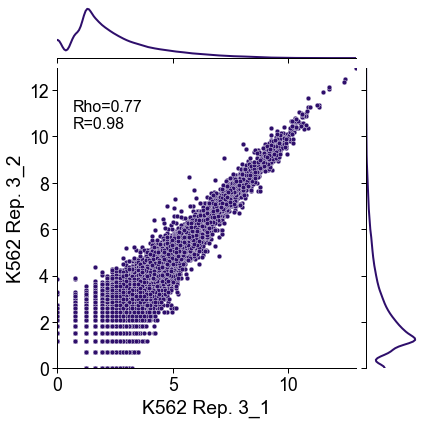

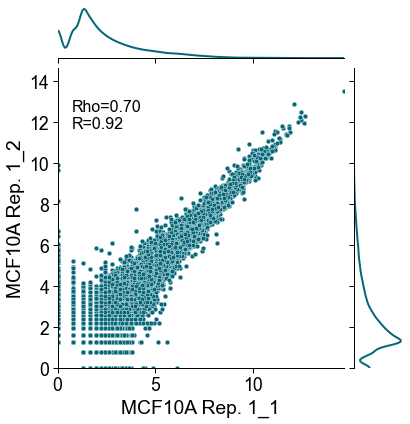

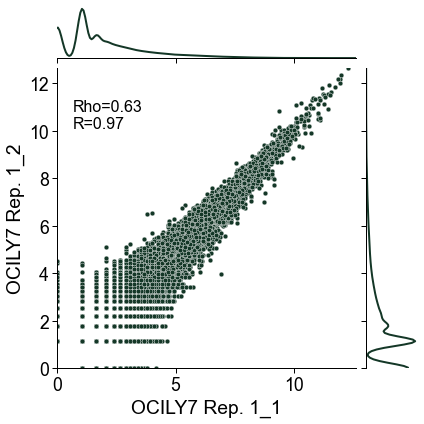

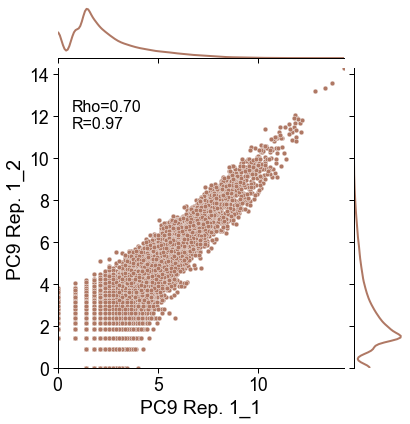

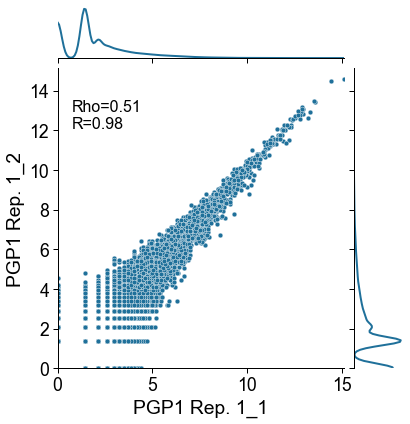

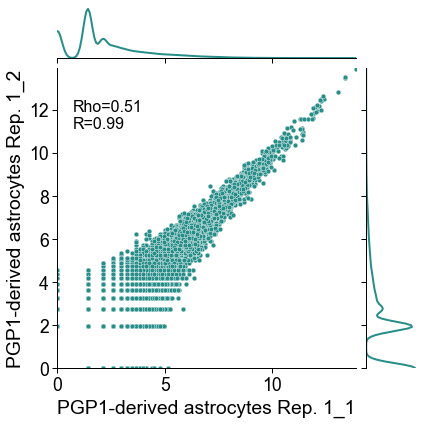

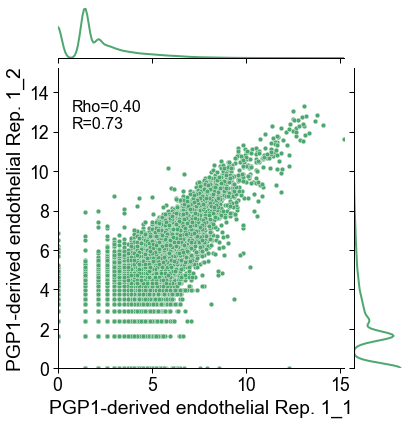

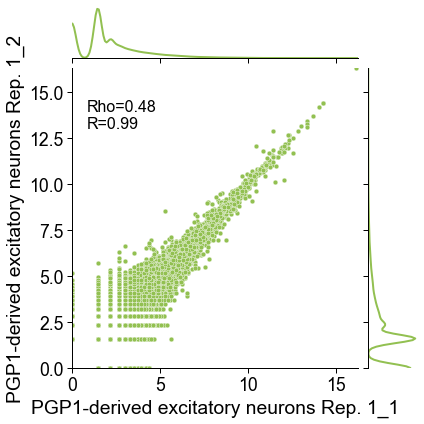

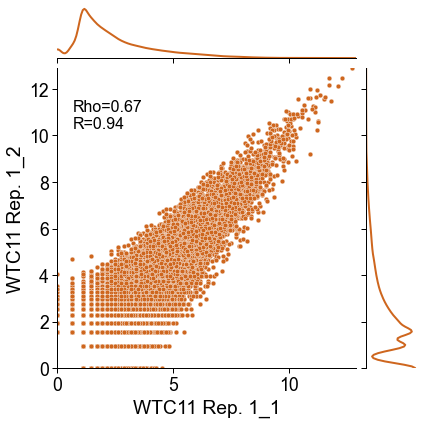

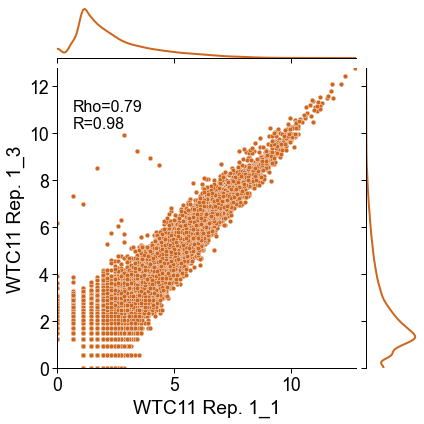

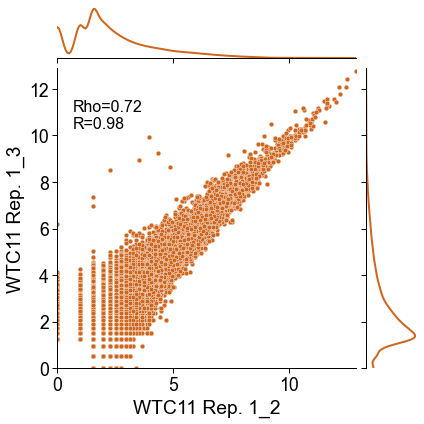

In [10]:
fnames = []
samples = []
rhos = []
rs = []
for i, p in enumerate(all_pairs):
    sample = p[0].rsplit('_', 2)[0]
    x = p[0]
    y = p[1]
    
    temp = df[[x, y]].copy(deep=True)
    # temp['sample'] = sample
    
    # remove transcripts expressed >1 TPM
    temp_det = det_df.transpose()[[x, y]].copy(deep=True)
    det_tids = temp_det.loc[temp_det.any(axis=1)].index.tolist()
    temp = temp.loc[det_tids]

    rho, p = st.spearmanr(temp[x].tolist(), temp[y].tolist())
    r, p2 = st.pearsonr(temp[x].tolist(), temp[y].tolist())
    samples.append(sample)
    rhos.append(rho)
    rs.append(r)
    
    # add pseudocounts and plot log2tpm
    temp = temp+1
    temp = np.log2(temp)
    lim = (0, max(temp[x].max(), temp[y].max()))
    
    g = sns.JointGrid(data=temp, x=x, y=y, ylim=lim, xlim=lim)
    g.plot_joint(sns.scatterplot, color=c_dict[sample])
    g.plot_marginals(sns.kdeplot, color=c_dict[sample], linewidth=2)
    
    # g.plot_marginals(sns.distplot, kde=True)
    # g = sns.jointplot(temp, x=x, y=y, color=c_dict[sample],
    #                   ylim=lim, xlim=lim, kind='kde', marginal_kws={'linewidth':2}) 
    for d, ax in zip([x,y], ['x','y']):
        label = meta_df.loc[meta_df.dataset==d, 'sample_display'].values[0]
        label += f" Rep. {'_'.join(d.rsplit('_',2)[-2:])}"
        if ax == 'x':
            g.ax_joint.set_xlabel(label)
        elif ax == 'y':
            g.ax_joint.set_ylabel(label)
    plt.text(.05, .8, 'Rho={:.2f}\nR={:.2f}'.format(rho,r), transform=g.ax_joint.transAxes,
              size=16)
    fname = f'figures/biorep_transcript_corr_{x}_{y}.png'
    plt.savefig(fname)
    fnames.append(fname)
    # plt.show()
    # plt.close(g)
    # break

In [11]:
import matplotlib.image as mpimg

56


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6


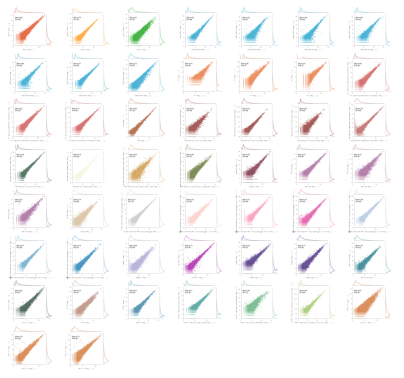

In [12]:
# mm = 0.0393701  # mm in inches
# f, axarr = plt.subplots(8, 7, squeeze=True, figsize=(180*mm, 170*mm))
# axs = []
# for i in range(axarr.shape[0]):
#     for j in range(axarr.shape[1]):
#         axs.append(axarr[i][j])
# print(len(axs))
# for i, f in enumerate(fnames):
#     axs[i].imshow(mpimg.imread(f))
# # plt.show()
# plt.savefig('figures/maybe.pdf')

mm = 0.0393701  # mm in inches
f, axarr = plt.subplots(8, 7, squeeze=True, figsize=(180*mm, 170*mm))
axs = []
for i in range(axarr.shape[0]):
    for j in range(axarr.shape[1]):
        axs.append(axarr[i][j])
print(len(axs))
for i, f in enumerate(fnames):
    axs[i].imshow(mpimg.imread(f))

for j in axs:
    j.spines['right'].set_visible(False)
    j.spines['top'].set_visible(False)
    j.spines['left'].set_visible(False)
    j.spines['bottom'].set_visible(False)
    j.set_xticklabels('')
    j.set_yticklabels('')
    j.set_xticks([])
    j.set_yticks([])
    
# plt.show()

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('figures/maybe.pdf', dpi=1000, layout='tight')

# Plot dist of the correlations

In [13]:
df = pd.DataFrame()
df['sample'] = samples
df['spearman_rho'] = rhos
df['pearson_r'] = rs

In [14]:
# ax = sns.scatterplot(df, x='spearman_rho', y='pearson_r', hue='sample',
#                 palette=c_dict, legend=None,
#                 s=40, alpha=0.75)
# ax.set(xlim=(.35,1.05), ylim=(.7,1.05), xlabel='Spearman rho',
#        ylabel='Pearson r')
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

In [15]:
temp = df[['sample', 'spearman_rho']].rename({'spearman_rho':'corr_metric'}, axis=1)
temp['corr_type'] = 'spearman'
temp2 = df[['sample', 'pearson_r']].rename({'pearson_r':'corr_metric'}, axis=1)
temp2['corr_type'] = 'pearson'
df = pd.concat([temp, temp2], axis=0)

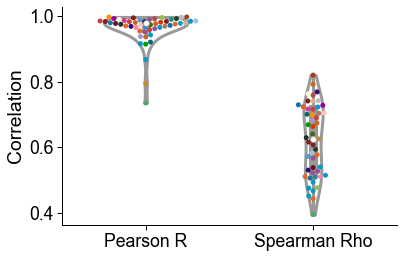

In [16]:
c_dict, order = get_biosample_colors()

cats = ['pearson', 'spearman']
cats_labels = ['Pearson R', 'Spearman Rho']
df['corr_type'] = df['corr_type'].astype('category')
df['corr_type'] = df['corr_type'].cat.reorder_categories(cats, ordered=True)
df = df.sort_values(by='corr_type')

ax2 = sns.swarmplot(df, x='corr_type', y='corr_metric')

n_t = len(df.loc[df.corr_type=='spearman'].index)
n_c = len(df.loc[df.corr_type=='pearson'].index)
d = {n_t: 'spearman', n_c: 'pearson'}
for i, cl in zip(range(len(ax2.collections)), cats):
    if isinstance(ax2.collections[i], mpl.collections.PathCollection):
        # try: 
        # cl = d[len(ax2.collections[i].properties()['facecolor'])]
        # except:
        #     continue
        colors = [c_dict[c] for c in df.loc[df.corr_type==cl, 'sample'].tolist()]
        ax2.collections[i].set_color(colors)
# ax.get_legend().remove()

ax = sns.violinplot(df, x='corr_type', y='corr_metric',
                    linewidth=3, fillcolor=None, cut=0, width=0.5, color='w', ax=ax2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set(ylabel='Correlation', xlabel='')
ax.set_xticklabels(cats_labels)

fname = 'figures/transcript_corr_summary.pdf'
plt.savefig(fname, dpi=500)

In [17]:
t = 'pearson'
min_corr = .9
temp = df.loc[df.corr_type == t].copy(deep=True)
n = len(temp.index)
n_num = len(temp.loc[temp.corr_metric>=min_corr].index)
print(f'{perc(n_num,n):.2f}% ({n_num}/{n}) of rep. pairs have {t} >= {min_corr}')

94.12% (48/51) of rep. pairs have pearson >= 0.9
